## Chapter 10 - Model Comparision and Hierarchical Modelling

- [10.3.2 - Hierarchical MCMC computation of relative model probability (Two factories of coins)](#10.3.2---Hierarchical-MCMC-computation-of-relative-model-probability)
 - [Model 1 - One theta variable ](#Model-1---One-theta-variable)
 - [Model 2 - Two theta variables without pseudo priors](#Model-2---Two-theta-variables-without-pseudo-priors)
 - [Model 3 - Two theta variables with pseudo priors = true prior](#Model-3---Two-theta-variables-with-pseudo-priors-=-true-prior)
 - [Model 4 - Two theta variables with pseudo priors that mimic posteriors ](#Model-4---Two-theta-variables-with-pseudo-priors-that-mimic-posteriors)

In [1]:
# %load ../../standard_import.txt
import pandas as pd
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt
import seaborn as sns

from theano.tensor import eq
from IPython.display import Image
from matplotlib import gridspec

%matplotlib inline
plt.style.use('seaborn-white')

color = '#87ceeb'

### 10.3.2 - Hierarchical MCMC computation of relative model probability

#### Model (Kruschke, 2015)

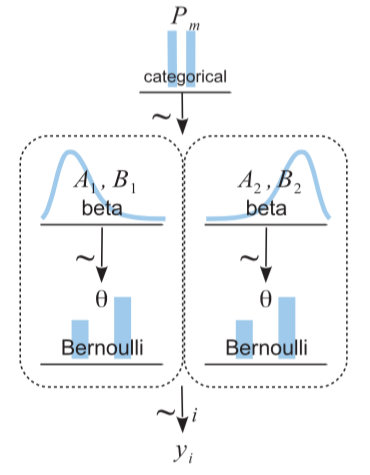

In [2]:
Image('images/fig10_2.png', width=300)

### Model 1 - One theta variable 
Coin is flipped nine times, resulting in six heads.

In [3]:
with pm.Model() as hierarchical_model:
    m = pm.Categorical('m', np.asarray([.5, .5]))
    
    kappa = 12
    
    omega = pm.math.switch(eq(m, 0), .25, .75)
    
    theta = pm.Beta('theta', omega*(kappa)+1, (1-omega)*(kappa)+1)
    
    y = pm.Bernoulli('y', theta, observed=[1,1,1,1,1,1,0,0,0])    

In [4]:
with hierarchical_model:
    trace = pm.sample(15000, init=None, tune=7500, nuts_kwargs={'target_accept': 0.95})

Assigned BinaryGibbsMetropolis to m
Assigned NUTS to theta_logodds__
100%|██████████| 15000/15000 [00:12<00:00, 1207.03it/s]


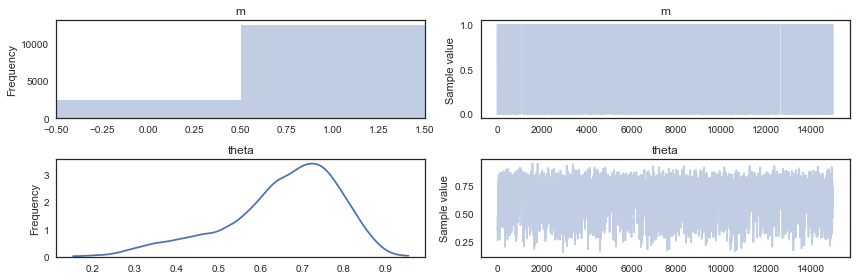

In [5]:
pm.traceplot(trace);

In [6]:
trace_df = (pm.trace_to_dataframe(trace)
            .set_index('m'))
trace_df.head()

,theta
m,
0,0.260908
0,0.260908
0,0.385121
0,0.367330
0,0.432857


#### Figure 10.4 (lower frame)

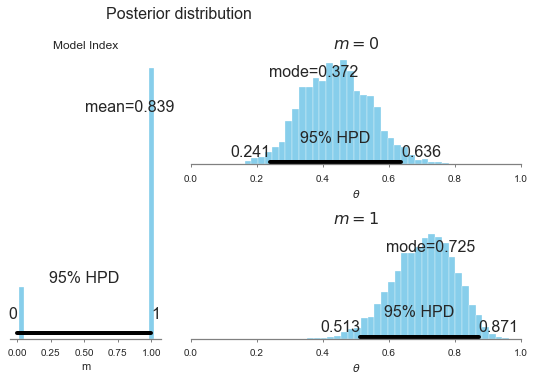

In [7]:
fig = plt.figure(figsize=(10,5))

font_d = {'size':16}
burnin=250

# Define gridspec
gs = gridspec.GridSpec(2, 4)
ax1 = plt.subplot(gs[0:,1])
ax2 = plt.subplot(gs[0,2:])
ax3 = plt.subplot(gs[1,2:])

# Distplot m
pm.plot_posterior(np.asarray(trace_df.index), ax=ax1, color=color)
ax1.set_xlabel('m')
ax1.set_title('Model Index')

# Distplot theta (m=0)
pm.plot_posterior(trace_df.loc[0].as_matrix().ravel()[burnin:], point_estimate='mode', ax=ax2, color=color)
ax2.set_title(r'$m = 0$', fontdict=font_d)

# Distplot theta (m=1)
pm.plot_posterior(trace_df.loc[1].as_matrix().ravel()[burnin:], point_estimate='mode', ax=ax3, color=color)
ax3.set_title(r'$m = 1$', fontdict=font_d)

for ax in [ax2, ax3]:
    ax.set(xlim=(0,1), xlabel=r'$\theta$')

fig.suptitle('Posterior distribution', size=16, y=1.05)
    
fig.tight_layout(w_pad=2);

### Model 2 - Two theta variables without pseudo priors
Coin is flipped nine times, resulting in six heads.

In [8]:
with pm.Model() as hierarchical_model2:
    m = pm.Categorical('m', np.asarray([.5, .5]))
    
    omega_0 = .25
    kappa_0 = 12
    theta_0 = pm.Beta('theta_0', omega_0*(kappa_0)+1, (1-omega_0)*(kappa_0)+1)
    
    omega_1 = .75
    kappa_1 = 12
    theta_1 = pm.Beta('theta_1', omega_1*(kappa_1)+1, (1-omega_1)*(kappa_1)+1)
    
    theta = pm.math.switch(eq(m, 0), theta_0, theta_1)
    
    y2 = pm.Bernoulli('y2', theta, observed=[1,1,1,1,1,0,0,0])    

In [9]:
with hierarchical_model2:
    trace2 = pm.sample(15000, init=None, tune=7500, nuts_kwargs={'target_accept': 0.95})

Assigned BinaryGibbsMetropolis to m
Assigned NUTS to theta_0_logodds__
Assigned NUTS to theta_1_logodds__
100%|██████████| 15000/15000 [00:18<00:00, 802.97it/s]


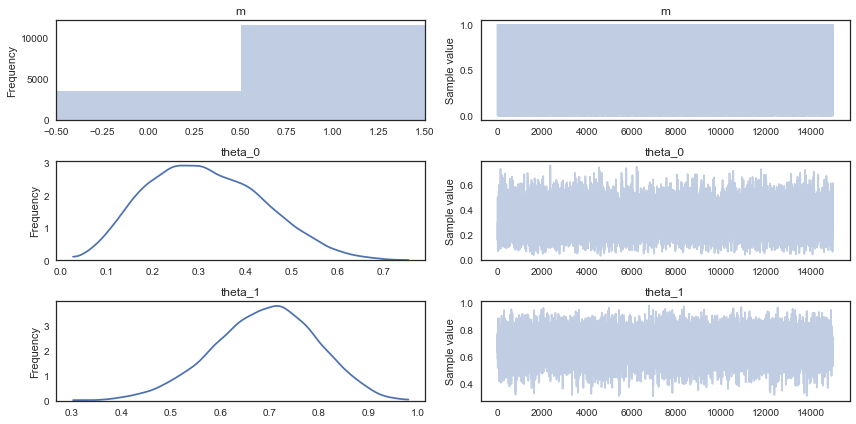

In [10]:
pm.traceplot(trace2);

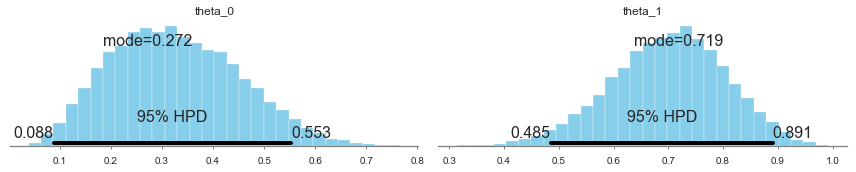

In [11]:
pm.plot_posterior(trace2, varnames=['theta_0', 'theta_1'], point_estimate='mode', color=color);

### Model 3 - Two theta variables with pseudo priors = true prior
Coin is flipped 30 times, resulting in 17 heads.

In [12]:
with pm.Model() as hierarchical_model3:
    m = pm.Categorical('m', np.asarray([.5, .5]))
    
    # Theta0
    kappa_0_true_p = 20
    kappa_0_pseudo_p = 20
    kappa_0 = pm.math.switch(eq(m, 0), kappa_0_true_p, kappa_0_pseudo_p)
    omega_0_true_p = .10
    omega_0_pseudo_p = .10
    omega_0 = pm.math.switch(eq(m, 0), omega_0_true_p, omega_0_pseudo_p)
    theta_0 = pm.Beta('theta_0', omega_0*(kappa_0)+1, (1-omega_0)*(kappa_0)+1)
    
    # Theta1    
    kappa_1_true_p = 20
    kappa_1_pseudo_p = 20 
    kappa_1 = pm.math.switch(eq(m, 1), kappa_1_true_p, kappa_1_pseudo_p)
    omega_1_true_p = .90
    omega_1_pseudo_p = .90
    omega_1 = pm.math.switch(eq(m, 1), omega_1_true_p, omega_1_pseudo_p)
    theta_1 = pm.Beta('theta_1', omega_1*(kappa_1)+1, (1-omega_1)*(kappa_1)+1)
    
    theta = pm.math.switch(eq(m, 0), theta_0, theta_1)
    
    y3 = pm.Bernoulli('y3', theta, observed=np.r_[17*[1], 13*[0]])

In [13]:
with hierarchical_model3:
    trace3 = pm.sample(15000, init=None, tune=7500, nuts_kwargs={'target_accept': 0.95})

Assigned BinaryGibbsMetropolis to m
Assigned NUTS to theta_0_logodds__
Assigned NUTS to theta_1_logodds__
100%|██████████| 15000/15000 [00:23<00:00, 638.53it/s]


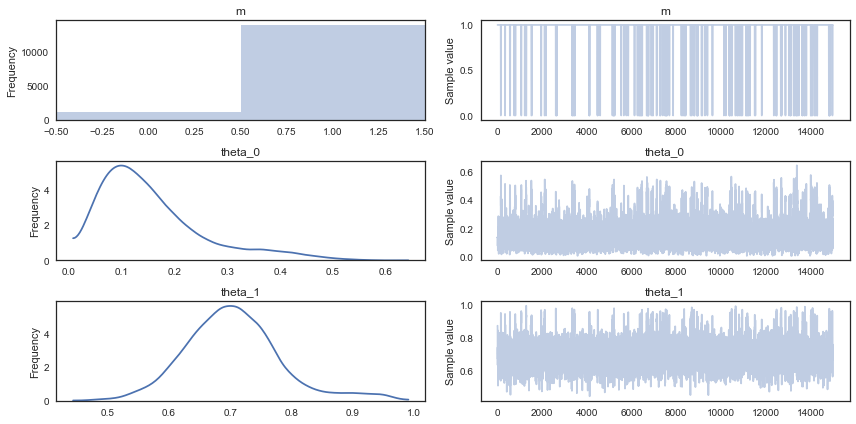

In [14]:
pm.traceplot(trace3);

In [15]:
trace3_df = (pm.trace_to_dataframe(trace3)
             .set_index('m')[['theta_0', 'theta_1']])
trace3_df.head()

,theta_0,theta_1
m,,
1,0.137179,0.870261
1,0.137179,0.870261
1,0.135234,0.766113
1,0.134598,0.763736
1,0.140438,0.744769


#### Figure 10.5 (lower part)

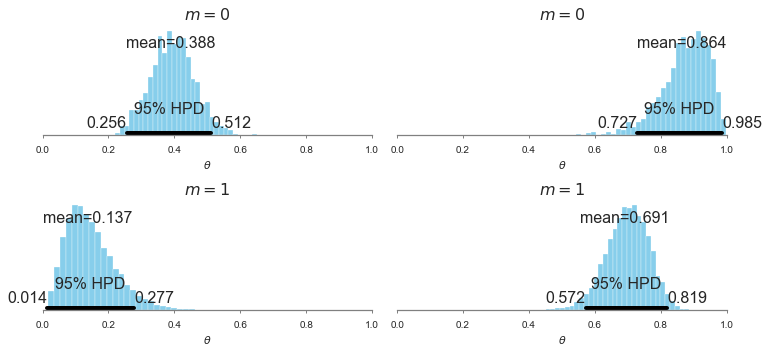

In [16]:
fig = plt.figure(figsize=(10,5))

font_d = {'size':16}

# Define gridspec
gs = gridspec.GridSpec(2, 2)
ax1 = plt.subplot(gs[0,0])
ax2 = plt.subplot(gs[0,1])
ax3 = plt.subplot(gs[1,0])
ax4 = plt.subplot(gs[1,1])

# Distplot theta0 when m = 0 (true prior)
pm.plot_posterior(trace3_df.loc[0, 'theta_0'].as_matrix()[burnin:], ax=ax1, color=color)
ax1.set_title(r'$m = 0$', fontdict=font_d)

# Distplot theta1 when m = 0 (pseudo prior)
pm.plot_posterior(trace3_df.loc[0, 'theta_1'].as_matrix()[burnin:], ax=ax2, color=color)
ax2.set_title(r'$m = 0$', fontdict=font_d)

# Distplot theta0 when m = 1 (pseudo prior)
pm.plot_posterior(trace3_df.loc[1, 'theta_0'].as_matrix()[burnin:], ax=ax3, color=color)
ax3.set_title(r'$m = 1$', fontdict=font_d)

# Distplot theta1 when m = 1 (true prior)
pm.plot_posterior(trace3_df.loc[1, 'theta_1'].as_matrix()[burnin:], ax=ax4, color=color)
ax4.set_title(r'$m = 1$', fontdict=font_d)

for ax in fig.axes:
    ax.set(xlim=(0,1), xlabel=r'$\theta$')

fig.tight_layout();

### Model 4 - Two theta variables with pseudo priors that mimic posteriors 
Coin is flipped 30 times, resulting in 17 heads.

In [17]:
with pm.Model() as hierarchical_model4:
    m = pm.Categorical('m', np.asarray([.5, .5]))
    
    # Theta0
    kappa_0_true_p = 20
    kappa_0_pseudo_p = 50
    kappa_0 = pm.math.switch(eq(m, 0), kappa_0_true_p, kappa_0_pseudo_p)
    omega_0_true_p = .10
    omega_0_pseudo_p = .40
    omega_0 = pm.math.switch(eq(m, 0), omega_0_true_p, omega_0_pseudo_p)
    theta_0 = pm.Beta('theta_0', omega_0*(kappa_0)+1, (1-omega_0)*(kappa_0)+1)
    
    # Theta1    
    kappa_1_true_p = 20
    kappa_1_pseudo_p = 50 
    kappa_1 = pm.math.switch(eq(m, 1), kappa_1_true_p, kappa_1_pseudo_p)
    omega_1_true_p = .90
    omega_1_pseudo_p = .70
    omega_1 = pm.math.switch(eq(m, 1), omega_1_true_p, omega_1_pseudo_p)
    theta_1 = pm.Beta('theta_1', omega_1*(kappa_1)+1, (1-omega_1)*(kappa_1)+1)
    
    theta = pm.math.switch(eq(m, 0), theta_0, theta_1)
    
    y4 = pm.Bernoulli('y4', theta, observed=np.r_[17*[1], 13*[0]])

In [18]:
with hierarchical_model4:
    trace4 = pm.sample(15000, init=None, tune=7500, nuts_kwargs={'target_accept': 0.95})

Assigned BinaryGibbsMetropolis to m
Assigned NUTS to theta_0_logodds__
Assigned NUTS to theta_1_logodds__
100%|██████████| 15000/15000 [00:21<00:00, 713.22it/s]


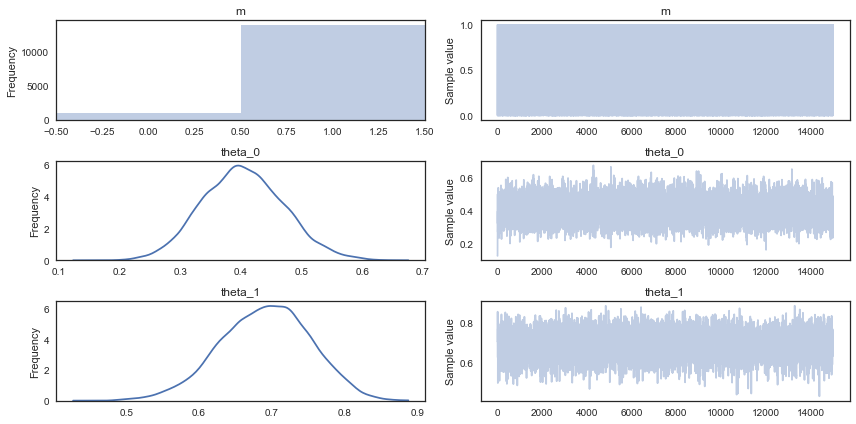

In [19]:
pm.traceplot(trace4);

In [20]:
trace4_df = (pm.trace_to_dataframe(trace4)
            .set_index('m')[['theta_0', 'theta_1']])
trace4_df.head()

,theta_0,theta_1
m,,
1,0.123516,0.704873
0,0.123516,0.704873
1,0.274739,0.706441
0,0.462185,0.760957
1,0.476560,0.787478


#### Figure 10.6 (lower part)

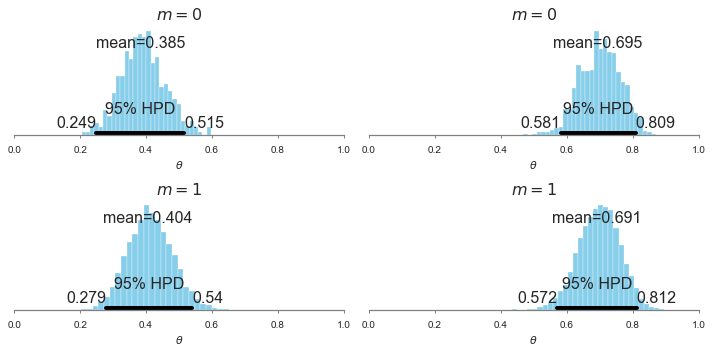

In [21]:
fig = plt.figure(figsize=(10,5))

font_d = {'size':16}

# Define gridspec
gs = gridspec.GridSpec(2, 2)
ax1 = plt.subplot(gs[0,0])
ax2 = plt.subplot(gs[0,1])
ax3 = plt.subplot(gs[1,0])
ax4 = plt.subplot(gs[1,1])

# Distplot theta0 when m = 0 (true prior)
pm.plot_posterior(trace4_df.loc[0, 'theta_0'].as_matrix()[burnin:], ax=ax1, color=color)
ax1.set_title(r'$m = 0$', fontdict=font_d)

# Distplot theta1 when m = 0 (pseudo prior)
pm.plot_posterior(trace4_df.loc[0, 'theta_1'].as_matrix()[burnin:], ax=ax2, color=color)
ax2.set_title(r'$m = 0$', fontdict=font_d)

# Distplot theta0 when m = 1 (pseudo prior)
pm.plot_posterior(trace4_df.loc[1, 'theta_0'].as_matrix()[burnin:], ax=ax3, color=color)
ax3.set_title(r'$m = 1$', fontdict=font_d)

# Distplot theta1 when m = 1 (true prior)
pm.plot_posterior(trace4_df.loc[1, 'theta_1'].as_matrix()[burnin:], ax=ax4, color=color)
ax4.set_title(r'$m = 1$', fontdict=font_d)

for ax in fig.axes:
    ax.set(xlim=(0,1), xlabel=r'$\theta$')

fig.tight_layout();